In [29]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import WikipediaNetwork
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv

In [6]:
from utility import utils
from importlib import reload
reload(utils)

<module 'utility.utils' from '/home/reef557/pr/py_code/classification_gnn/utility/utils.py'>

# Model, train/val/test functions

Two convolutional layers, convolution described here: [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, output_size)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [4]:
def train(model, optimizer, criterion, data):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index) # get logits

    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # compute loss

    loss.backward()
    optimizer.step()
    
    return loss

def get_val_loss(model, optimizer, criterion, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)

        loss = criterion(out[data.val_mask], data.y[data.val_mask])

    return loss

def test(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # pick class with highest probability
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # compute accuracy
    return test_acc

# Read/download data

In [36]:
dataset = Planetoid(root='data/Planetoid', name='Cora') # uncomment needed dataset
# dataset = Planetoid(root='data/Planetoid', name='Pubmed')
# dataset = Planetoid(root='data/Planetoid', name='Citeseer')
# dataset = WikipediaNetwork(root='data/WikipediaNetwork', name='Squirrel')

data = dataset[0]

# The default features

In [25]:
model = GCN(input_size=dataset.num_features, 
            hidden_size=16, 
            output_size=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


print(model)

print_every = 25

train_loss_history = []
val_loss_history = []

for epoch in range(1, 101):
    
    loss = train(model, optimizer, criterion, data)
    train_loss_history.append(loss.item())

    val_loss = get_val_loss(model, optimizer, criterion, data)
    val_loss_history.append(val_loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Epoch: 025, Loss: 0.1938
Epoch: 050, Loss: 0.0486
Epoch: 075, Loss: 0.0510
Epoch: 100, Loss: 0.0422


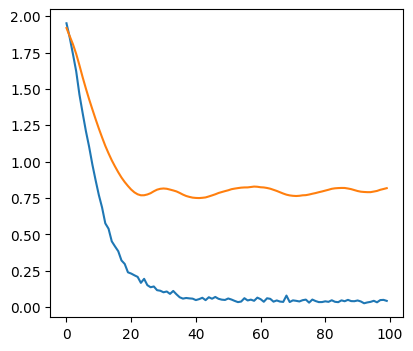

In [26]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.show()

In [27]:
test_acc = test(model, data)

print(f"Test accuracy = {test_acc}")

Test accuracy = 0.791


# Laplacian-based positional encodings

In [ ]:
eigenmap = utils.get_eigenmap_from_edge_index(data.edge_index, data.x.shape[0], d=8)

In [19]:
data.x = np.concat([data.x, eigenmap], axis=1)
data.x = torch.tensor(data.x, dtype=torch.float32)

In [20]:
model = GCN(input_size=data.x.shape[1], 
            hidden_size=16, 
            output_size=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


print(model)

print_every = 25

train_loss_history = []
val_loss_history = []

for epoch in range(1, 101):
    
    loss = train(model, optimizer, criterion, data)
    train_loss_history.append(loss.item())

    val_loss = get_val_loss(model, optimizer, criterion, data)
    val_loss_history.append(val_loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

GCN(
  (conv1): GCNConv(1449, 16)
  (conv2): GCNConv(16, 7)
)
Epoch: 025, Loss: 0.1855
Epoch: 050, Loss: 0.0412
Epoch: 075, Loss: 0.0365
Epoch: 100, Loss: 0.0420


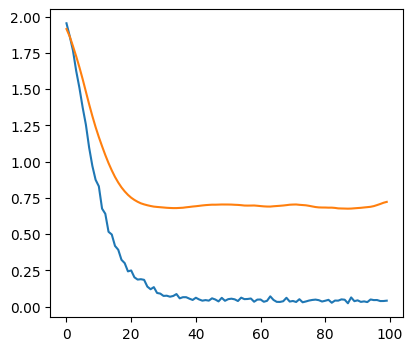

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.show()

In [22]:
test_acc = test(model, data)

print(f"Test accuracy = {test_acc}")

Test accuracy = 0.805


# Sheaf based positional encodings

In [ ]:
stalk_dim = 3
conn_laplacian = utils.local_pca_alignment(np.array(data.x), data.edge_index, stalk_dim)

In [ ]:
emb_dim = 8
eigenmap = utils.get_eigenmap(conn_laplacian, emb_dim)

In [ ]:
eigenmap.shape

(8124, 8)

In [15]:
data.x.shape

torch.Size([2708, 1433])

In [ ]:
eigenmaps = eigenmap.reshape((2708, -1))

In [27]:
test = np.copy(data.x)

In [19]:
test.shape

(2708, 1433)

In [33]:
data.x = np.concat([test, eigenmaps], axis=1)

In [39]:
data.x = torch.tensor(data.x, dtype=torch.float32)

/tmp/ipykernel_610/428024982.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.x = torch.tensor(data.x, dtype=torch.float32)


In [40]:
model = GCN(input_size=dataset.num_features+24, 
            hidden_size=16, 
            output_size=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


print(model)

print_every = 25

train_loss_history = []
val_loss_history = []

for epoch in range(1, 101):
    
    loss = train(model, optimizer, criterion, data)
    train_loss_history.append(loss.item())

    val_loss = get_val_loss(model, optimizer, criterion, data)
    val_loss_history.append(val_loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

GCN(
  (conv1): GCNConv(1457, 16)
  (conv2): GCNConv(16, 7)
)
Epoch: 025, Loss: 0.1427
Epoch: 050, Loss: 0.0616
Epoch: 075, Loss: 0.0346
Epoch: 100, Loss: 0.0318


In [43]:
test_acc = test(model, data)

print(f"Test accuracy = {test_acc}")

Test accuracy = 0.783
